# Preliminary Test on Orbit ARMA Model

In [1]:
from datetime import datetime, timedelta
import datetime as dt 

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import orbit
from orbit.models import DLT,ETS, KTRLite, LGT, ARMA
from orbit.utils.simulation import make_trend, make_regression
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape

In [2]:
%load_ext autoreload
%autoreload 2

## Data Simulation

<class 'numpy.ndarray'>


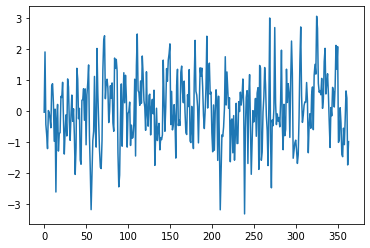

In [3]:
# make the data
n = 365 # hourly for 1 year 

x0 = np.random.normal(0, 1, n)
x1 = np.random.normal(0, 1, n)
x2 = np.random.normal(0, 1, n)
x3 = np.random.normal(0, 1, n)
x4 = np.random.normal(0, 1, n)
x5 = np.random.normal(0, 1, n)
x6 = np.random.normal(0, 1, n)
x7 = np.random.normal(0, 1, n)
x8 = np.random.normal(0, 1, n)
x9 = np.random.normal(0, 1, n)

X = np.vstack([x0, x1]).transpose()
   
eta = np.random.normal(0, 1.0, n)

rho = [0.40, -0.25,0.15,-0.1, 0.05]
beta = [0.00, -0.00]
y = eta.copy()
for i in range(2, n):
    #y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-7] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-2] + rho[2]*y[i-3]  + rho[3]*y[i-4] + rho[4]*y[i-5] + x0[i]*beta[0]+ x1[i]*beta[1]+ eta[i]

     
#plt.plot(y)
plt.plot(y[1:500])
print(type(X))

In [4]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i]=hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]

In [5]:
df = pd.DataFrame(X, columns=['a1', 'a2'])
df['hours'] = hours
df['y'] = y

In [6]:
df_train = df[0:180]
df_test = df[180:n]

## Prediction Comparison orbit-ml vs. statsmodels

### AR1 

In [7]:
mod = ARMA(
        #regressor_col=['a1'],
        lm_first=0,
        estimator='stan-mcmc',
        date_col='hours',
        response_col='y',
        ma_lags = [1] ,
    num_warmup=3000,
    num_sample=3000,
)
mod.fit(df_train)
pred = mod.predict(df_test)
pred = pred.rename(columns={
    'prediction': 'prediction_orbit',
    'prediction_5': 'prediction_5_orbit',
    'prediction_95': 'prediction_95_orbit',
})

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):750 and samples(per chain):750.


In [8]:
pred = mod.predict(df)
pred

,hours,prediction_5,prediction,prediction_95
0,2021-01-01 00:00:00,-1.660517,-0.015993,1.592778
1,2021-01-01 01:00:00,-1.648338,-0.081908,1.518188
2,2021-01-01 02:00:00,-1.633929,0.001327,1.671577
3,2021-01-01 03:00:00,-0.916046,0.748013,2.391183
4,2021-01-01 04:00:00,-2.175348,-0.483787,1.176541
...,...,...,...,...
360,2021-01-16 00:00:00,-1.686644,0.007288,1.653117
361,2021-01-16 01:00:00,-1.727324,-0.010992,1.654865
362,2021-01-16 02:00:00,-1.804341,-0.029390,1.770245
363,2021-01-16 03:00:00,-1.728237,-0.043774,1.666155


In [9]:
y = pd.Series(df_train['y'])
arma_mod = ARIMA(y, order=(0, 0, 1))
arma_res = arma_mod.fit()
forecast = arma_res.get_forecast(185)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.10)
pred['prediction_5_statsmodel'] = yhat_conf_int['lower y']
pred['prediction_statsmodel'] = yhat
pred['prediction_95_statsmodel'] = yhat_conf_int['upper y']

KeyError: 'prediction_5_orbit'

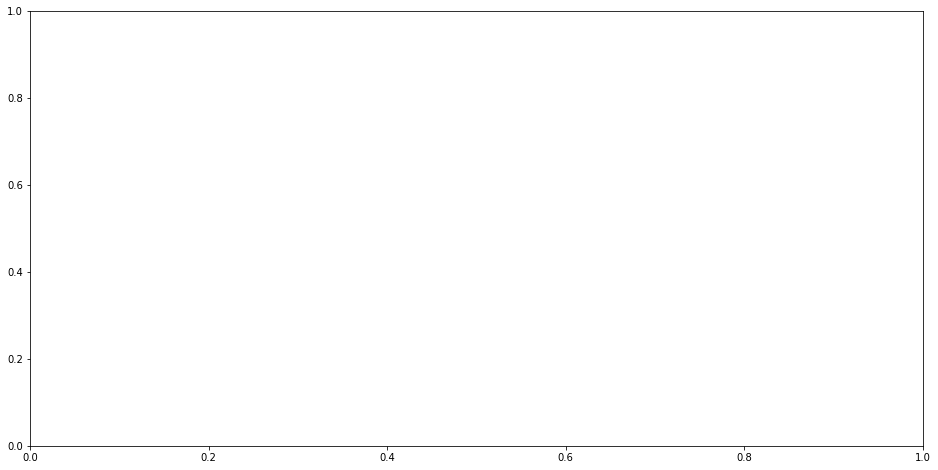

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(pred['hours'], pred['prediction_5_orbit'], label='orbit')
ax.plot(pred['hours'], pred['prediction_statsmodel'], label='statsmodel')